In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# --- Load CSV (ground truth or reference) ---
csv_df = pd.read_csv("tracking_csv.csv")

# --- Load JSON (model predictions) ---
with open("tracking_results.json", "r") as f:
    tracking_data = json.load(f)

# Flatten JSON into DataFrame
records = []
for frame in tracking_data["tracking_results"]:
    ts = frame["timestamp"]
    frame_no = frame["frame_number"]
    for p in frame["players"]:
        records.append({
            "frame": frame_no,
            "timestamp": ts,
            "player_id": p["player_id"],
            "confidence": p["confidence"],
            "width": p["bbox"]["x2"] - p["bbox"]["x1"],
            "height": p["bbox"]["y2"] - p["bbox"]["y1"]
        })

df = pd.DataFrame(records)

# --- Aggregate metrics per frame ---
metrics = df.groupby(["frame", "timestamp"]).agg(
    mean_conf=("confidence", "mean"),
    det_count=("player_id", "count"),
    bbox_var=("width", "std")
).reset_index()


threshold = 0.7
metrics["low_conf"] = metrics["mean_conf"] < threshold


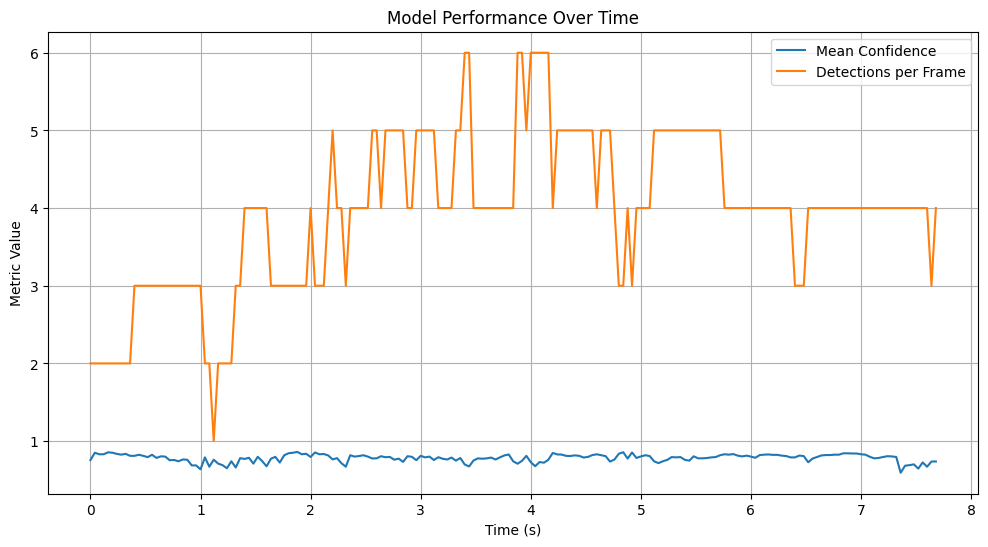

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(metrics["timestamp"], metrics["mean_conf"], label="Mean Confidence")
plt.plot(metrics["timestamp"], metrics["det_count"], label="Detections per Frame")
plt.xlabel("Time (s)")
plt.ylabel("Metric Value")
plt.title("Model Performance Over Time")
plt.legend()
plt.grid()
plt.show()


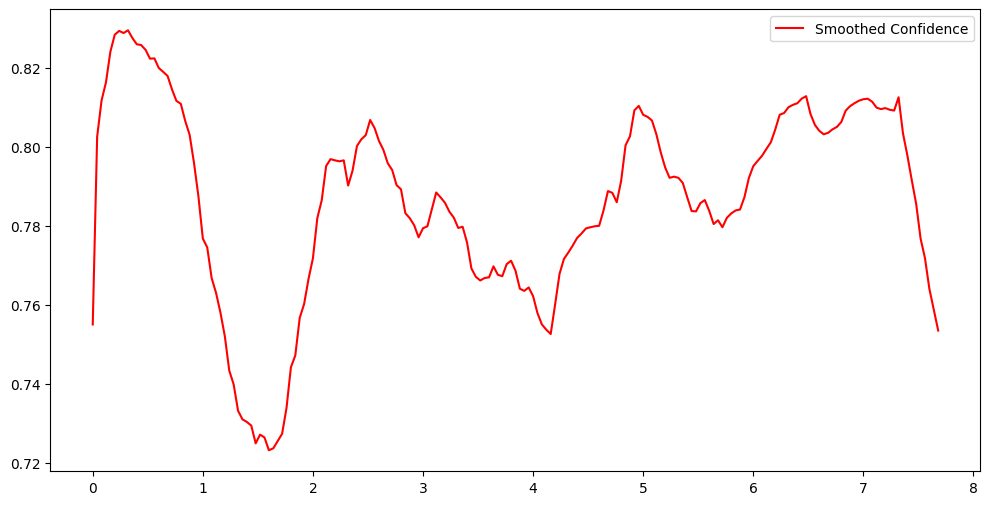

In [ ]:
metrics["conf_smooth"] = metrics["mean_conf"].rolling(window=20, min_periods=1).mean()
plt.figure(figsize=(12,6))
plt.plot(metrics["timestamp"], metrics["conf_smooth"], label="Smoothed Confidence", color="red")
plt.legend()
plt.show()


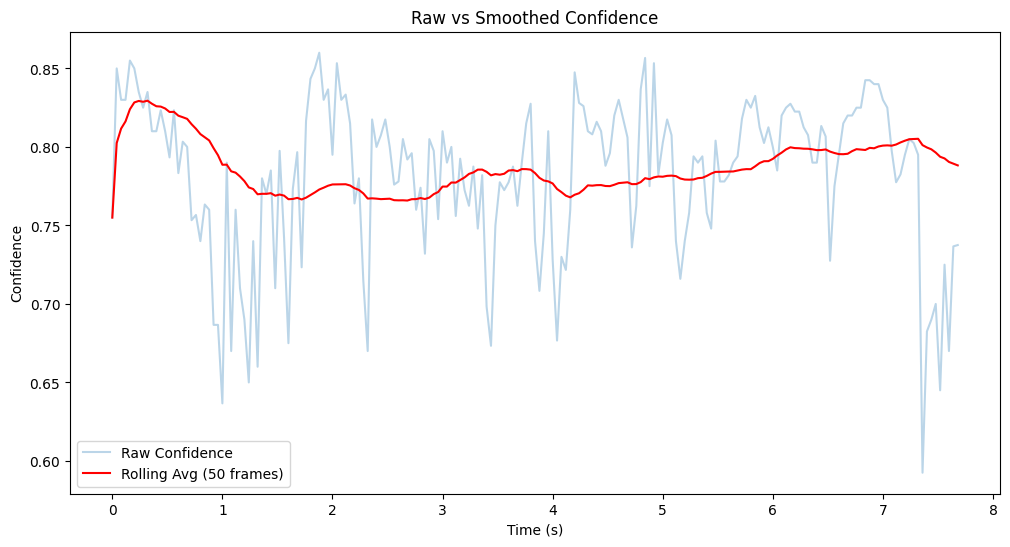

In [ ]:
metrics["rolling_conf"] = metrics["mean_conf"].rolling(window=50, min_periods=1).mean()

plt.figure(figsize=(12,6))
plt.plot(metrics["timestamp"], metrics["mean_conf"], alpha=0.3, label="Raw Confidence")
plt.plot(metrics["timestamp"], metrics["rolling_conf"], color="red", label="Rolling Avg (50 frames)")
plt.xlabel("Time (s)")
plt.ylabel("Confidence")
plt.title("Raw vs Smoothed Confidence")
plt.legend()
plt.show()


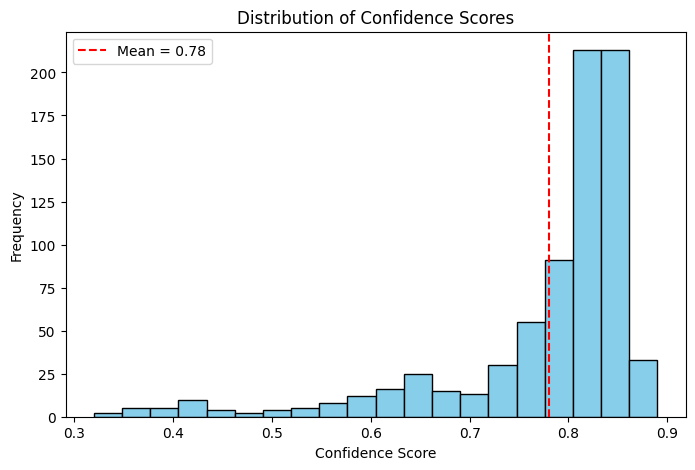

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(df["confidence"], bins=20, color="skyblue", edgecolor="black")
plt.axvline(df["confidence"].mean(), color="red", linestyle="--", label=f"Mean = {df['confidence'].mean():.2f}")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.title("Distribution of Confidence Scores")
plt.legend()
plt.show()


/tmp/ipython-input-1297908080.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


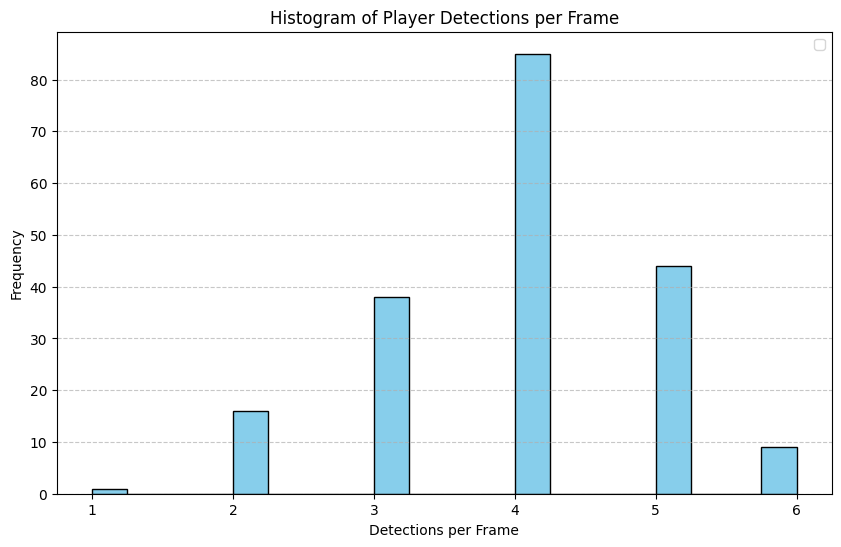

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(metrics["det_count"], bins=20, color="skyblue", edgecolor="black")


plt.xlabel("Detections per Frame")
plt.ylabel("Frequency")
plt.title("Histogram of Player Detections per Frame")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


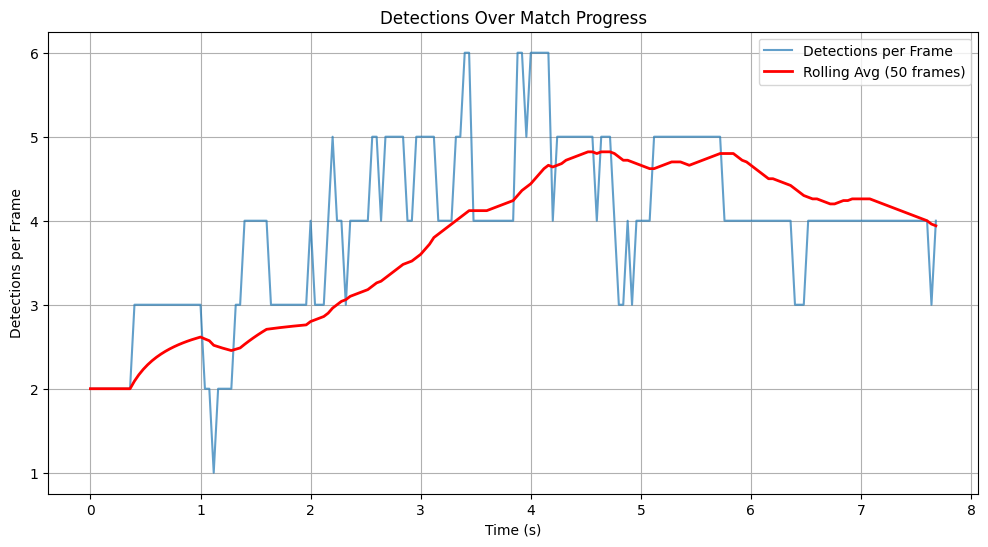

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(metrics["timestamp"], metrics["det_count"], label="Detections per Frame", alpha=0.7)

metrics["det_count_smooth"] = metrics["det_count"].rolling(window=50, min_periods=1).mean()
plt.plot(metrics["timestamp"], metrics["det_count_smooth"], color="red", linewidth=2,
         label="Rolling Avg (50 frames)")

plt.xlabel("Time (s)")
plt.ylabel("Detections per Frame")
plt.title("Detections Over Match Progress")
plt.legend()
plt.grid()
plt.show()


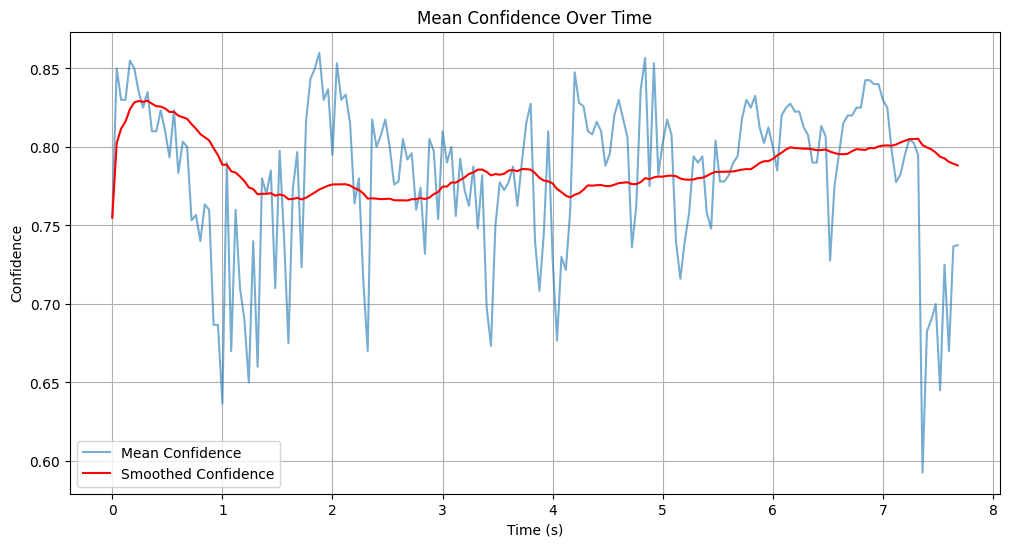

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(metrics["timestamp"], metrics["mean_conf"], label="Mean Confidence", alpha=0.6)
plt.plot(metrics["timestamp"],
         metrics["mean_conf"].rolling(window=50, min_periods=1).mean(),
         color="red", label="Smoothed Confidence")

plt.xlabel("Time (s)")
plt.ylabel("Confidence")
plt.title("Mean Confidence Over Time")
plt.legend()
plt.grid()
plt.show()


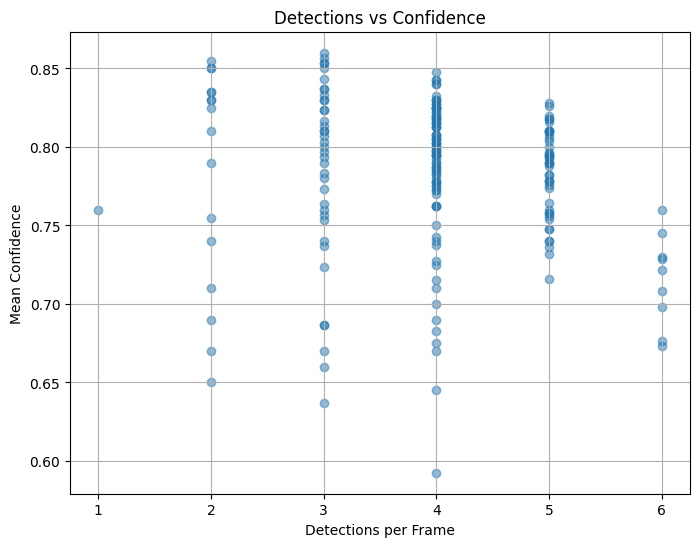

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(metrics["det_count"], metrics["mean_conf"], alpha=0.5)
plt.xlabel("Detections per Frame")
plt.ylabel("Mean Confidence")
plt.title("Detections vs Confidence")
plt.grid()
plt.show()


<Figure size 1000x600 with 0 Axes>

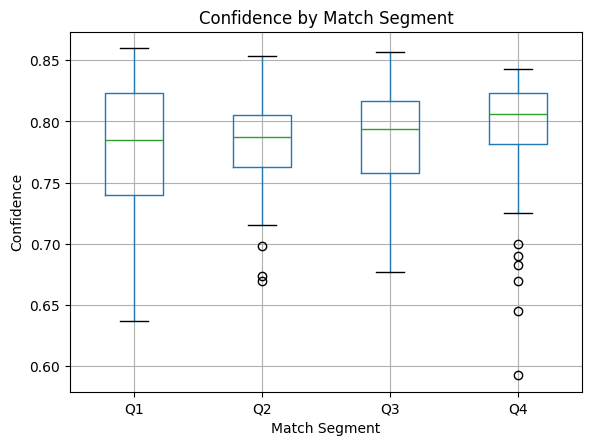

In [ ]:
import pandas as pd

metrics["time_bin"] = pd.cut(metrics["timestamp"], bins=4, labels=["Q1","Q2","Q3","Q4"])

plt.figure(figsize=(10,6))
metrics.boxplot(column="mean_conf", by="time_bin")
plt.xlabel("Match Segment")
plt.ylabel("Confidence")
plt.title("Confidence by Match Segment")
plt.suptitle("")  # remove extra title
plt.show()


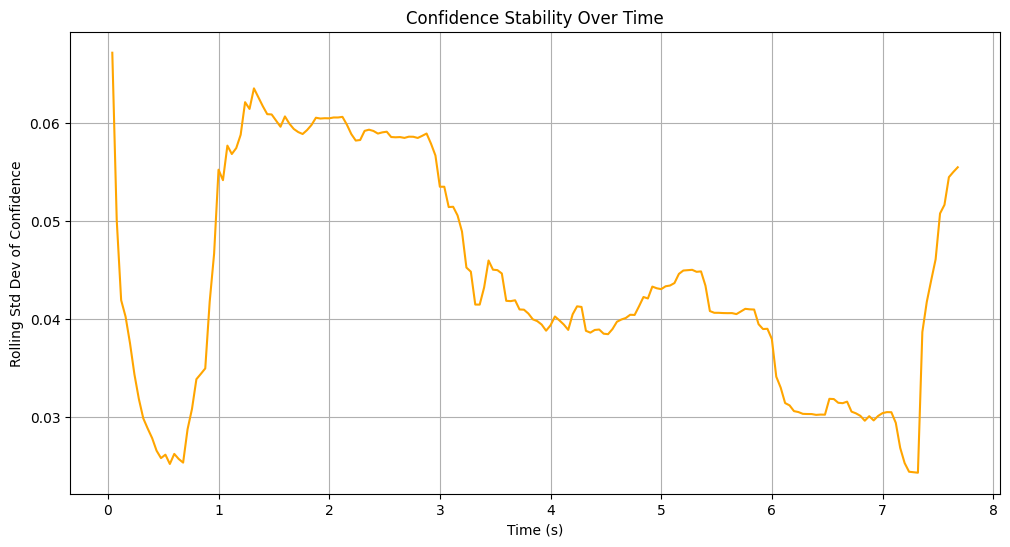

In [ ]:
metrics["conf_std"] = metrics["mean_conf"].rolling(window=50, min_periods=1).std()

plt.figure(figsize=(12,6))
plt.plot(metrics["timestamp"], metrics["conf_std"], color="orange")
plt.xlabel("Time (s)")
plt.ylabel("Rolling Std Dev of Confidence")
plt.title("Confidence Stability Over Time")
plt.grid()
plt.show()
